# Translational Regulation  
during and post heat shock  
10/28/15

In [4]:
# from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import gridspec
%matplotlib inline
import matplotlib as mpl

## Recap: Model  
Can the changes in translation and chaperone levels following heat shock be explained by the behavior of Pab1?

Pab1 assembles during heat, releasing short poly-A stretches and binding longer stretches (demonstrated in vivo). This (presumably) creates a surplus of soluble transcripts which can be translated by the remaining soluble translation machinery; examples of such transcripts are the heat shock inducible proteins such as chaperones.

## Setup and Species

Species: **Pab**, **iPab** (insoluble _Pab1_), **C** (used relative amount of _HSP104_ as starting value, otherwise undetermined chaperone which acts catalytically), **mRNA$_C$**, **Pab:mRNA$_C$** (Pab bound to the chaperone mRNA), **mRNA$_B$** (representing bulk cellular mRNA), **Pab:mRNA$_B$**.

Assumptions: Constant amount of Pab1. Chaperone can be translated and degraded. Heat shock mRNA is induced in a temperature-dependent fashion and can be degraded. Bulk cellular RNA is constant.

Experimentally determined parameters/constraints: mRNA levels (hs induction and bulk), chaperone levels (relative to mass spec data HSP104), chaperone decay rate. 

**Chemical equations:**  

$
\begin{aligned}
Pab & \xrightarrow{k_1(T)^*} iPab
\newline
iPab + C & \xrightarrow{k_2} Pab + C
\newline
mRNA_C & \xrightarrow{k_3} C
\newline
C & \xrightarrow{k_4} \emptyset
\newline
\emptyset & \xrightarrow{k_5(T)^*} mRNA_C
\newline
Pab + mRNA_C & \overset{k_6} \leftrightharpoons Pab:mRNA_C
\newline
& \thinspace \thinspace ^{k_{-6}}
\newline
Pab + mRNA_B & \overset{k_6} \leftrightharpoons Pab:mRNA_B
\newline
& \thinspace \thinspace ^{k_{-6}}
\newline
mRNA_C & \xrightarrow{k_7} \emptyset
\end{aligned}
$

$^*$ (T) denotes rates that are a function of temperature

**Rate equations:**

$
\begin{align}
		\frac{d[Pab]}{dt} & = k_2[Pab][C] - k_1(T)[Pab] - k_6[Pab][mRNA_C] + k_{-6}[Pab:mRNA_C]
		\newline
		\frac{d[iPab]}{dt} &= k_1(T)[Pab] - k_2[Pab][C]
		\newline
		\frac{d[C]}{dt} & = k_3[mRNA_C] - k_4[C]
		\newline
		\frac{d[mRNA_C]}{dt} & = k_5(T) - k_6[Pab][mRNA_C] + k_{-6}[Pab:mRNA_C] - k_7[mRNA_C]
		\newline
		\frac{[Pab:mRNA_C]}{dt} & = k_6[Pab][mRNA_C] - k_{-6}[Pab:mRNA_C]
        \newline
        \frac{[Pab:mRNA_B]}{dt} & = k_6[Pab][mRNA_B] - k_{-6}[Pab:mRNA_B]
\end{align}
$

In [18]:
# Constant parameters
total_HSP104 = 28591 # unshocked conditdions
HSP104_deg = 0.011363 # min^-1
total_Pab1 = 100115 # unshocked conditions
#Pab1_deg = 0.000891 # min^-1; basically 0 for our purposes
base_HSP104_mRNA = 4.7

# Base simulation function
def run_simulation(deriv, zinit, temp_vec, time_vec, tstep):
    """Given a function deriv which can be acted upon by the numpy integrater odeint in which temperature
    is represented by the variable T, run a simulation of the system and return the timecourse.
    """
    assert len(temp_vec) == len(time_vec)
    for i in range(len(time_vec)):
        if i == 0:
            T = temp_vec[i]
            T_list = [T, T]
            times = np.arange(0, time_vec[i], tstep)
            old_z = odeint(deriv, zinit, times, args=(T,))
        else:
            T = temp_vec[i]
            time = np.arange(time_vec[i-1], time_vec[i], tstep)
            z = odeint(deriv, old_z[-1], time, args=(T,))
            old_z = np.vstack((old_z, z))
            times = np.concatenate((times, time))
            T_list.append(T)
    
    return old_z, times, T_list

def plot_timecourse(old_z, times, T_list, time_vec):
    """Plot output of run_simulation."""
    names = ['Pab1', 'Assembled Pab1', 'Chaperone', 'mRNA', 'Pab1:mRNA', '$mRNA_B$', '$Pab:mRNA_B$']
    colors = ['royalblue', 'firebrick', 'lightgreen', 'darkgreen', 'k', 'indigo', 'darkorange']

    f, ax = plt.subplots(figsize=(9, 7))
    #f = plt.figure(figsize=(10, 6))
    #gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5])
    #ax2 = plt.subplot(gs[0])
    #ax2.step([time_vec[0]] + time_vec, T_list, c='k', linewidth=2)
    #ax2.set_ylabel('T (K)')
    #ax2.set_ylim(300, 320)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    #ax = plt.subplot(gs[1], sharex=ax2)
    #simpleaxis(ax2)
    for i in xrange(5):
        ax.plot(times, old_z[:, i], label=names[i], c=colors[i], linewidth=4)
    ax.set_xlabel('time (min)')
    ax.set_ylabel('species count')
    ax.legend(loc=0)
    simpleaxis(ax)
    plt.tight_layout()
    
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [3]:
# model schemes
def Pabreg(z, t, T):
    Ea = 10. # assembly reaction activation energy (arb. units for now)
    Ea2 = 120. # mRNA production activation energy (arb. units)
    k1 = .1*np.exp(Ea*(1-(303./T))) # Deactivation (M^-1*min^-1)
    k2 = .000002 # Reactivation 
    k3 = .4 # Protein synthesis M^-1*min^-1
    #k4 = HSP104_deg # Protein degradation
    k4 = 0.02 # very close to the (log growth) determined value, for what it's worth 
    k5 = 10.*np.exp(Ea2*(1-(303./T))) # mRNA production rate (min^-1)
    k6 = .000001 # Pab-mRNA binding rate M^-2*min^-1
    km6 = .01 # Pab-mRNA unbinding rate M^-1*min^-1
    k7 = .003 # mRNA decay rate    
    
    Pab = z[0]
    iPab = z[1]
    C = z[2]
    mRNAC = z[3]
    Pab_mRNAC = z[4]
    mRNAB = z[5]
    Pab_mRNAB = z[6]
    
    dPab = -k1*Pab + k2*iPab*C - k6*Pab*mRNAC + km6*Pab_mRNAC - k6*Pab*mRNAB + km6*Pab_mRNAB
    diPab = k1*Pab - k2*iPab*C
    dC = k3*mRNAC - k4*C
    dmRNAC = k5 - k6*Pab*mRNAC + km6*Pab_mRNAC - k7*mRNAC
    dPab_mRNAC = k6*Pab*mRNAC - km6*Pab_mRNAC
    dmRNAB = km6*Pab_mRNAB - k6*Pab*mRNAB
    dPab_mRNAB = k6*Pab*mRNAB - km6*Pab_mRNAB
    
    return np.array([dPab, diPab, dC, dmRNAC, dPab_mRNAC, dmRNAB, dPab_mRNAB])

def mRNAdecay(z, t, T):
    Ea = 10. # assembly reaction activation energy (arb. units for now)
    Ea2 = 120. # mRNA production activation energy (arb. units)
    k1 = .1*np.exp(Ea*(1-(303./T))) # Deactivation (M^-1*min^-1)
    k2 = .000002 # Reactivation 
    k3 = .2 # Protein synthesis M^-1*min^-1
    #k4 = HSP104_deg # Protein degradation
    k4 = 0.02 # very close to the (log growth) determined value, for what it's worth 
    k5 = 10.*np.exp(Ea2*(1-(303./T))) # mRNA production rate (min^-1)
    k6 = .000001 # Pab-mRNA binding rate M^-2*min^-1
    km6 = .01 # Pab-mRNA unbinding rate M^-1*min^-1
    k7 = .008 # mRNA decay rate    
    
    Pab = z[0]
    iPab = z[1]
    C = z[2]
    mRNAC = z[3]
    Pab_mRNAC = z[4]
    mRNAB = z[5]
    Pab_mRNAB = z[6]
    
    dPab = -k1*Pab + k2*iPab*C - k6*Pab*mRNAB + km6*Pab_mRNAB
    diPab = k1*Pab - k2*iPab*C
    dC = k3*mRNAC - k4*C
    dmRNAC = k5 - k7*mRNAC
    dPab_mRNAC = 0
    dmRNAB = km6*Pab_mRNAB - k6*Pab*mRNAB
    dPab_mRNAB = k6*Pab*mRNAB - km6*Pab_mRNAB
    
    return np.array([dPab, diPab, dC, dmRNAC, dPab_mRNAC, dmRNAB, dPab_mRNAB])

## Approach 1
An attempt to delineate between two hypotheses. The simplest explanation for the decrease in chaperone levels over time during recovery could be that these transcripts (marked by short, A-rich 5' UTRS) are degraded more rapidly during recovery than other transcripts. Barring any data on this phenomenon (see Castells-Roca 2011?), we can adjust parameters of the model (assuming no Pab1 binding) to mimic the experimental data as well.

In [4]:
mpl.rcParams['axes.linewidth'] = 3.0
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'light'
mpl.rcParams['font.size'] = 25

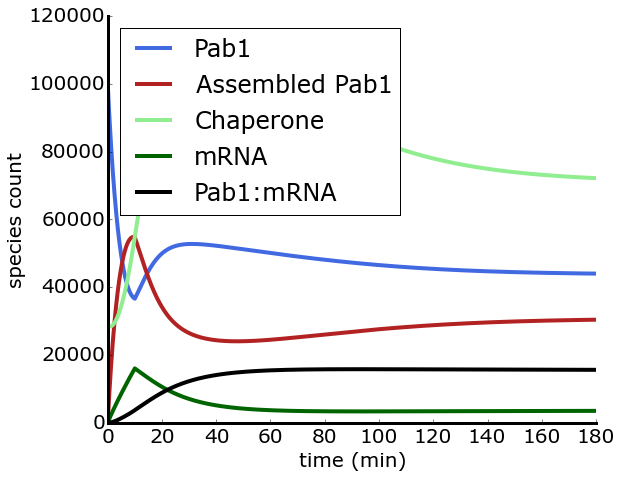

In [19]:
time_vec = [.1, 10., 180.]
temp_vec = [317, 317, 303]
zinit = np.array([100000, 0, total_HSP104, 5, 0, 12200, 0])
x = run_simulation(Pabreg, zinit, temp_vec, time_vec, 0.001)

plot_timecourse(x[0], x[1], x[2], time_vec)
plt.savefig("PabRegsolution.pdf", dpi=300)

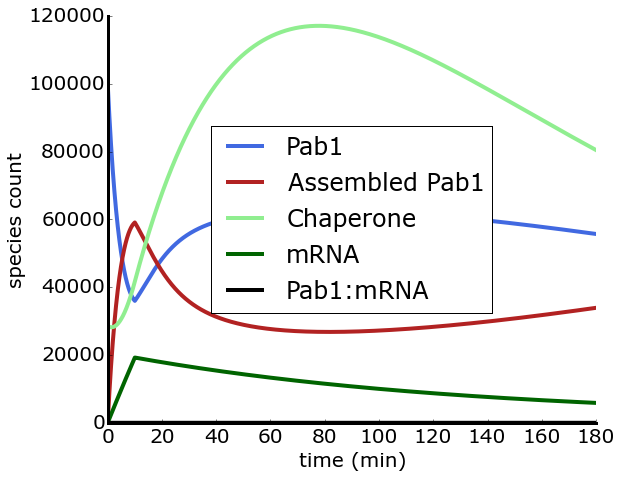

In [20]:
time_vec = [.1, 10., 180.]
temp_vec = [317, 317, 303]
zinit = np.array([100000, 0, total_HSP104, 5, 0, 12200, 0])
x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.001)

plot_timecourse(x[0], x[1], x[2], time_vec)
plt.savefig("mRNAsolution.pdf", dpi=300)

Now we can use these models to make predictions outside the regime in which they were parameterized. We can simulate extended heat shock:  
**Pab1-binding model:**

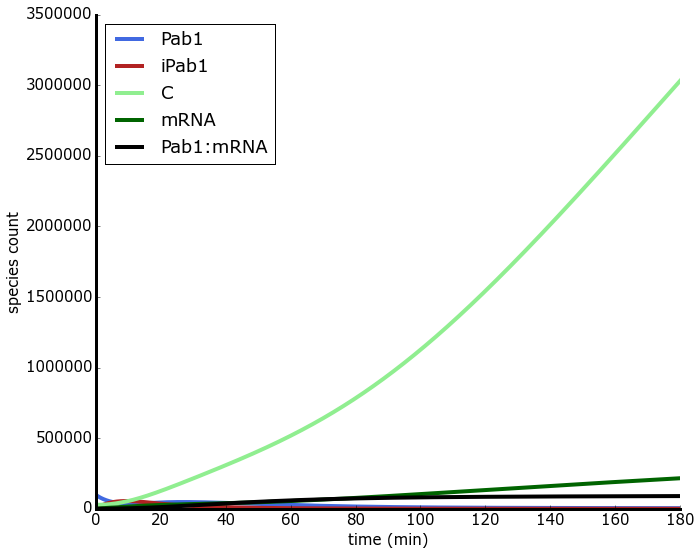

In [111]:
time_vec = [.1, 10., 180.]
temp_vec = [317, 317, 317]
zinit = np.array([total_Pab1, 0, total_HSP104, 5, 0, 12200, 0])
x = run_simulation(Pabreg, zinit, temp_vec, time_vec, 0.001)

plot_timecourse(x[0], x[1], x[2], time_vec)

**mRNA decay model:**  

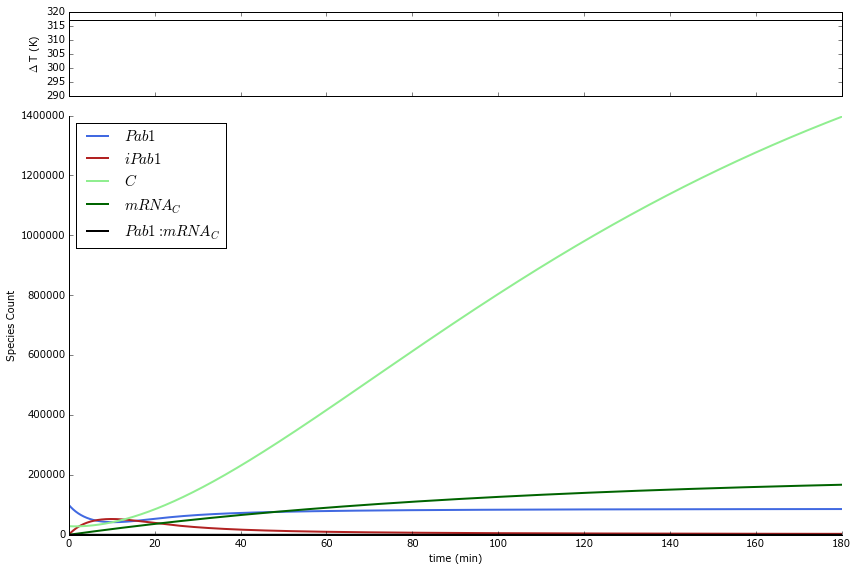

In [20]:
time_vec = [.1, 10., 180.]
temp_vec = [317, 317, 317]
zinit = np.array([total_Pab1, 0, total_HSP104, 5, 0, 12200, 0])
x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.001)

plot_timecourse(x[0], x[1], x[2], time_vec)

There is data (Castells-Roca 2011) on mRNA stabilities during extended mild heat shock. This indicates that transcription rates increase rapidly during initial heat shock, with peak mRNA levels reached after ~40 minutes of shock. Then levels seem to become constant, with the decay rate staying fairly constant during this time as well. This indicates a complex translational mechanism that may not be well-represented by a function of temperature alone.  

This reveals a weakness in the modeling strategy more than anything else. The amount of mRNA produced during a 10-15 minute heat shock must be massive, yet it likely does not continue at that rate unchecked as is seen here - modeling too far outside the regime in which the model was parameterized. Which leads us to...  

## Thought 2
Make predictions about the relative levels of chaperone produced during recovery as a function of total Pab1 levels (this can be maniuplated both in vitro and in vivo).

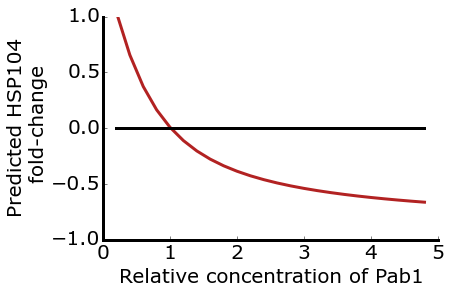

In [9]:
time_vec = [1., 10., 60.]
temp_vec = [317, 317, 303]

for i in xrange(20000, 500000, 20000):
    if i == 20000:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(Pabreg, zinit, temp_vec, time_vec, 0.01)
        data1 = np.concatenate(([i], x[0][-1]))
    else:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(Pabreg, zinit, temp_vec, time_vec, 0.01)
        xdata = np.concatenate(([i], x[0][-1]))
        data1 = np.vstack((xdata, data1))
        
for i in xrange(20000, 500000, 20000):
    if i == 20000:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.01)
        data2 = np.concatenate(([i], x[0][-1]))
    else:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.01)
        xdata = np.concatenate(([i], x[0][-1]))
        data2 = np.vstack((xdata, data2))
        
fig, ax = plt.subplots(figsize = (6, 4))     
ax.plot(data1[:, 0]/100000., data1[:, 3]/100000. - 1, c = "firebrick", linewidth=3)
ax.plot(data2[:, 0]/100000, data2[:, 3]/113761.91140299 - 1, c = "k", linewidth=3)
ax.set_xlabel("Relative concentration of Pab1")
ax.set_ylabel("Predicted HSP104 \n fold-change")
ax.set_ylim(-1, 1)
#ax.set_title("Pab1 Regulation Model", fontsize=15)
simpleaxis(ax)
plt.savefig("chap-level-prediction.pdf", dpi=200)

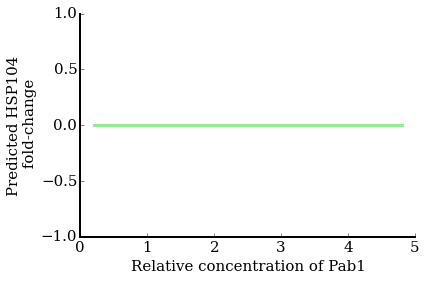

In [85]:
time_vec = [1., 10., 60.]
temp_vec = [317, 317, 303]

for i in xrange(20000, 500000, 20000):
    if i == 20000:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.01)
        data = np.concatenate(([i], x[0][-1]))
    else:
        zinit = np.array([i, 0, total_HSP104, 5, 0, 12200, 0])
        x = run_simulation(mRNAdecay, zinit, temp_vec, time_vec, 0.01)
        xdata = np.concatenate(([i], x[0][-1]))
        data = np.vstack((xdata, data))

        
fig, ax = plt.subplots(figsize = (6, 4))     
ax.plot(data[:, 0]/100000, data[:, 3]/113761.91140299 - 1, c = "lightgreen", linewidth=3)
ax.set_ylim(-1, 1)
ax.set_xlabel("Relative concentration of Pab1", fontsize=15)
ax.set_ylabel("Predicted HSP104 \n fold-change", fontsize=15)
#ax.set_title("mRNA Decay Model", fontsize=15)
simpleaxis(ax)
plt.savefig("mrna-chap-level-prediction.pdf", dpi=200)